In [1]:
# Imports
import pandas as pd
import pickle
import matplotlib

In [2]:
with open('cleaned_aqi_data.pkl', 'rb') as f:
    cleaned_aqi_data = pickle.load(f)

with open('site_data.pkl', 'rb') as f2:
    site_data = pickle.load(f2)

In [3]:
site_data = {year: [{'date-local': y['date_local'], 'reading': y['arithmetic_mean']} for y in site_data[year]] for year in site_data}

In [4]:
site_data

{2017: [{'date-local': '2017-03-01', 'reading': 0.031125},
  {'date-local': '2017-03-02', 'reading': 0.041957},
  {'date-local': '2017-03-03', 'reading': 0.037125},
  {'date-local': '2017-03-04', 'reading': 0.037708},
  {'date-local': '2017-03-05', 'reading': 0.037174},
  {'date-local': '2017-03-09', 'reading': 0.046958},
  {'date-local': '2017-03-06', 'reading': 0.025957},
  {'date-local': '2017-03-07', 'reading': 0.038348},
  {'date-local': '2017-03-08', 'reading': 0.045391},
  {'date-local': '2017-03-10', 'reading': 0.037708},
  {'date-local': '2017-03-11', 'reading': 0.04325},
  {'date-local': '2017-03-13', 'reading': 0.038917},
  {'date-local': '2017-03-14', 'reading': 0.037348},
  {'date-local': '2017-03-15', 'reading': 0.042},
  {'date-local': '2017-03-16', 'reading': 0.0435},
  {'date-local': '2017-03-17', 'reading': 0.039609},
  {'date-local': '2017-03-18', 'reading': 0.031875},
  {'date-local': '2017-03-19', 'reading': 0.034833},
  {'date-local': '2017-03-20', 'reading': 0.03

In [5]:
sorted_data = dict()

for year in site_data:
    sorted_data[year] = sorted(site_data[year], key=lambda x: x['date-local'])

In [6]:
cleaned_aqi_data

,Date,AQI
0,2017-01-01,33.0
1,2017-01-02,18.0
2,2017-01-03,6.0
3,2017-01-04,11.0
4,2017-01-05,13.0
...,...,...
2090,2022-09-22,21.0
2091,2022-09-23,8.0
2092,2022-09-24,12.0
2093,2022-09-25,12.0


In [7]:
combined_data = dict()

for year in sorted_data:
    combined_data[year] = []
    current_date = sorted_data[year][0]['date-local']
    total = sorted_data[year][0]['reading']
    num = 1
    for datum in sorted_data[year]:
        if datum['date-local'] == current_date:
            total += datum['reading']
            num += 1
        else:
            aqi = cleaned_aqi_data[cleaned_aqi_data['Date'] == current_date]['AQI']
            if len(aqi) > 0:
                aqi = aqi.iloc[0]
                combined_data[year].append({'Date': current_date, 'Ozone': total / num, 'AQI': aqi})
            current_date = datum['date-local']
            total = datum['reading']
            num = 1
    aqi = cleaned_aqi_data[cleaned_aqi_data['Date'] == current_date]['AQI']
    if len(aqi) > 0:
        aqi = aqi.iloc[0]
        combined_data[year].append({'Date': current_date, 'Ozone': total / num, 'AQI': aqi})

combined_data

{2017: [{'Date': '2017-02-28', 'Ozone': 0.03, 'AQI': 43.0},
  {'Date': '2017-03-01', 'Ozone': 0.032510250000000004, 'AQI': 37.0},
  {'Date': '2017-03-02', 'Ozone': 0.04083375, 'AQI': 40.0},
  {'Date': '2017-03-03', 'Ozone': 0.0368805, 'AQI': 37.0},
  {'Date': '2017-03-04', 'Ozone': 0.038212750000000004, 'AQI': 41.0},
  {'Date': '2017-03-05', 'Ozone': 0.03499575, 'AQI': 40.0},
  {'Date': '2017-03-06', 'Ozone': 0.02647725, 'AQI': 48.0},
  {'Date': '2017-03-07', 'Ozone': 0.04028925, 'AQI': 52.0},
  {'Date': '2017-03-08', 'Ozone': 0.046282750000000004, 'AQI': 45.0},
  {'Date': '2017-03-09', 'Ozone': 0.044145, 'AQI': 49.0},
  {'Date': '2017-03-10', 'Ozone': 0.039703749999999996, 'AQI': 40.0},
  {'Date': '2017-03-11', 'Ozone': 0.04325, 'AQI': 13.0},
  {'Date': '2017-03-13', 'Ozone': 0.037747, 'AQI': 39.0},
  {'Date': '2017-03-14', 'Ozone': 0.0375345, 'AQI': 37.0},
  {'Date': '2017-03-15', 'Ozone': 0.041897000000000004, 'AQI': 41.0},
  {'Date': '2017-03-16', 'Ozone': 0.043726999999999995, 'AQ

In [60]:
def fill_missing_ozone(df, start_date, end_date):
    expected_dates = pd.date_range(start=start_date, end=end_date)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').reindex(expected_dates).reset_index()
    df = df.rename(columns={'index': 'Date'})
    replacement_values = dict()
    for i in range(len(df)):
        if pd.isna(df.at[i, 'Ozone']):
            before_index = i - 1
            after_index = i + 1
            while before_index >= 0 and pd.isna(df.at[before_index, 'Ozone']):
                before_index -= 1
            while after_index < len(df) and pd.isna(df.at[after_index, 'Ozone']):
                after_index += 1
            if before_index < 0:
                val = df.at[after_index, 'Ozone']
            elif after_index >= len(df):
                val = df.at[before_index, 'Ozone']
            else:
                val = (df.at[before_index, 'Ozone'] + df.at[after_index, 'Ozone']) // 2
            replacement_values[i] = val
        aqi_data = cleaned_aqi_data[cleaned_aqi_data['Date'] == str(df.at[i, 'Date'])[:10]]
        df.at[i, 'AQI'] = aqi_data.iloc[0]['AQI']
    for i in range(len(df)):
        if i in replacement_values:
            df.at[i, 'Ozone'] = replacement_values[i]
    df = df[['Date', 'Ozone', 'AQI']]
    return df

In [61]:
# for year in combined_data:
df = pd.DataFrame(combined_data[2017])
df.iloc[-1]['Date']

'2017-10-31'

In [62]:
df

,Date,Ozone,AQI
0,2017-02-28,0.030000,43.0
1,2017-03-01,0.032510,37.0
2,2017-03-02,0.040834,40.0
3,2017-03-03,0.036880,37.0
4,2017-03-04,0.038213,41.0
...,...,...,...
236,2017-10-27,0.029079,37.0
237,2017-10-28,0.034700,39.0
238,2017-10-29,0.020931,23.0
239,2017-10-30,0.027365,31.0


Empty DataFrame
Columns: [Date, Ozone, AQI]
Index: []
Empty DataFrame
Columns: [Date, Ozone, AQI]
Index: []
Empty DataFrame
Columns: [Date, Ozone, AQI]
Index: []
Empty DataFrame
Columns: [Date, Ozone, AQI]
Index: []
Empty DataFrame
Columns: [Date, Ozone, AQI]
Index: []
Empty DataFrame
Columns: [Date, Ozone, AQI]
Index: []


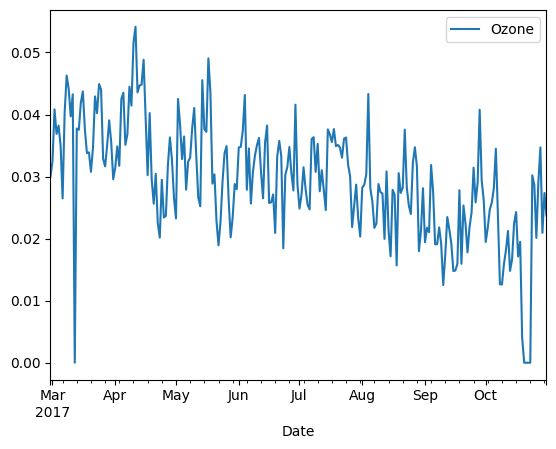

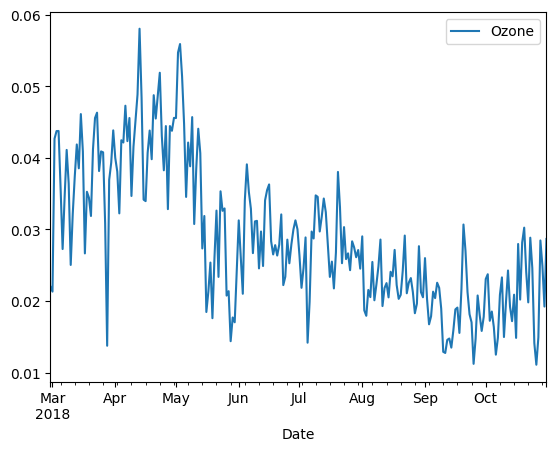

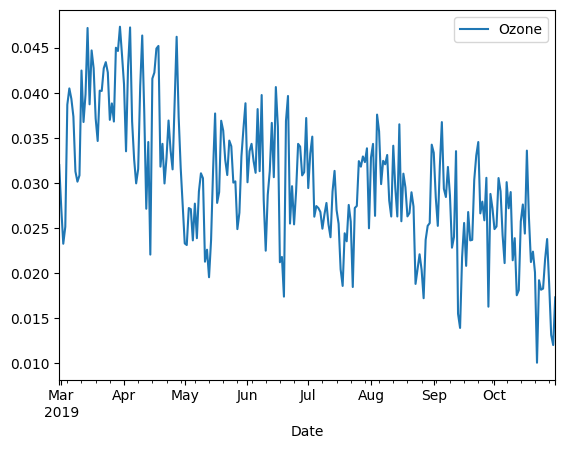

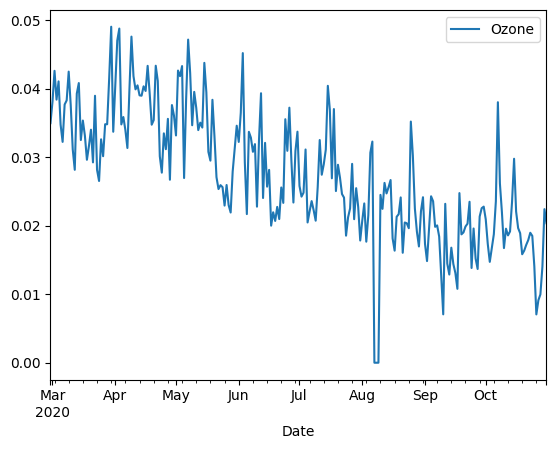

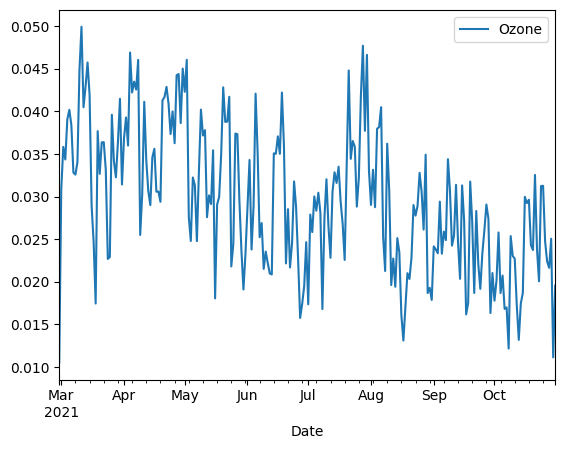

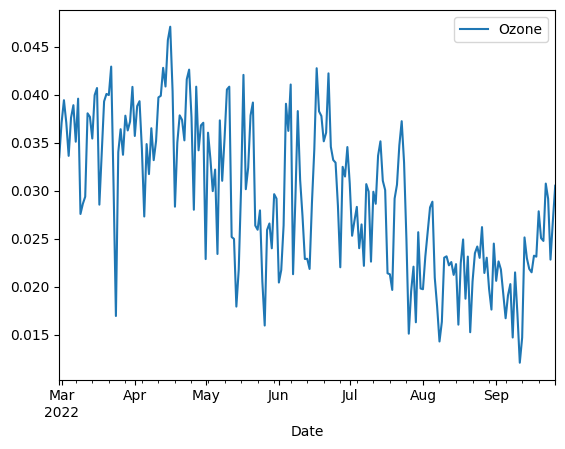

In [66]:
for year in combined_data:
    df = pd.DataFrame(combined_data[year])
    start_date = df.iloc[0]['Date']
    end_date = df.iloc[-1]['Date']
    df = fill_missing_ozone(df, start_date, end_date)

    with open(f'{year}-wozone.pkl', 'wb') as f:
        df.plot(x="Date", y="Ozone")
        print(df[pd.isnull(df['AQI'])])
        pickle.dump(df, f)